<a href="https://colab.research.google.com/github/yvrjsharma/JAX/blob/main/JAX_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX: PMap for parallelism and Advanced Autodiff
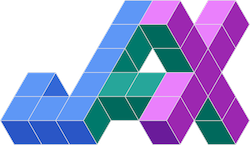

JAX has lots of cool features to evaluate your code parallely. This is also called SPMD, or Single-Program Multiple-Data code. In this technique same code or computation is run in parallel on different input data on different devices (e.g. TPUs)

You can use pmap() to write a piece of code suitable for running on one device as well as on multiple devices.



Lets start using TPUs for this one. If you are using this Colab notebook, make sure you change your Runtime to TPU.

In [ ]:
#Lets import the required libraries
import jax
import jax.numpy as jnp
import numpy as np

#transformation : higher order functions which take fuun as an input and outputs a transformed fun 
from jax import grad, jit, vmap, pmap
from jax import random

import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [ ]:
import jax
jax.devices() #Eight devices

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In order to ustilize all the cores that are available to us, lets create some array with batch size equal to the number of cores available.

Lets now perform a dummy computation - convolving a small array over this array which is spread across the cores. This dummy example will help us in understanding later how pmap() helps in speeding up more complex or bigger computations.  

In [ ]:
n_devices = jax.local_device_count()
x = np.arange(5)
xs = np.arange(5*n_devices).reshape(-1,5)  #40 unique values, arranged in 5 columns and 8 rows
w = np.array([2.,3.,4.])  #for convolving over the given metric
ws = np.stack([w] * n_devices)  #duplicating the same convolution kernel on 8 cores
x,w , xs, ws

(array([0, 1, 2, 3, 4]), array([2., 3., 4.]), array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39]]), array([[2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.]]))

In [ ]:
#Simple convolution example 
def convolve(w,x):
  output = []
  for i in range(1,len(x)-1):
    output.append(jnp.dot(x[i-1:i+2],w))
  return jnp.array(output)

convolve(w,x) #smaller array is convolved over another one

DeviceArray([11., 20., 29.], dtype=float32)

In [ ]:
#Lets first try the convolve operation over xs using just one device
#We can do so using vmap()
#convolve(ws,xs) #Error for incompatible shapes
jax.vmap(convolve)(ws,xs)

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)

In [ ]:
#Coolest thing in JAX is that you don't hav to change the function 
#When you need to run it on multiple devices
#Using pmap() this time
jax.pmap(convolve)(ws,xs)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

In [ ]:
#Another way of writing above code
#Using in_axes argument of pmap() 
#Works similar to vmap()
jax.pmap(convolve,in_axes=(None,0))(w,xs)  #Using w instead of ws

#'None' would mean to broadcast weight w across all the cores 
#'0' would mean that 0 dimension in xs matrix is the batch argument
#So, pmap will replicate w and distribute every row in xs to a device

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

* One thing to notice here is that now we have '**Sharded Device Arrays**' as an output instead if Device Array. This means that the data as well as the computation is sharded or distributed across multiple cores.

* Another thing to note here is that if we were to run another parallel computation, the elements would stay on their respective devices and that there won't be any cost incurred for moving data between devices.

* One more interesting thing to note here is that ```jax.pmap()``` does ```jit``` compile of the code additionally as part of its operations.

* In this example the array of five elements was distributed on every device, along with the single Kernel, there is **no communication happening across the multiple cores**.

We can choose while parallelizing the computation to have a communication between the multiple cores or not. We might have to train our Neural Netwrok model in a distributed fashion in which every core would receive a batch of data and then they will compute, communicate and cordinate among them to get the mean of gradients to update our ML model.

See below example for calculating the normalized values across each device so that the sum is 1. Here we need to pass the information across the devices.

In [ ]:
#Using same convolution example 
#Comunicate across devices this time
def normalized_convolve(w,x):
  output = []
  for i in range(1,len(x)-1):
    output.append(jnp.dot(x[i-1:i+2],w))
  output = jnp.array(output)

  return output / jax.lax.psum(output,axis_name= 'p')  #Trying to communicate across devices

jax.pmap(normalized_convolve,axis_name='p', in_axes=(None,0))(w,xs) #If you will sum all the row values for any column you will get 1
#Note the Sharded Device Array as the output 

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959785],
                    [0.07492582, 0.07746479, 0.07975871],
                    [0.10830861, 0.10915492, 0.10991956],
                    [0.14169139, 0.14084506, 0.14008042],
                    [0.17507419, 0.17253521, 0.17024128],
                    [0.20845698, 0.20422535, 0.20040214],
                    [0.24183977, 0.23591548, 0.23056298]], dtype=float32)

**value_and_grad()** function 
* It conveniently gives you both the function's value as well as its gradient.
* It will help in creating the model training pipeline using pure jax while getting the value as well as the gradient of the loss function. 

In [ ]:
from jax._src.api import value_and_grad
#Simple loss function - sum of square of error differences 
def sum_squared_error(x,y):
  return sum((x-y)**2)  #derivative wrto x will be 2(x-y)

x = jnp.arange(4, dtype=jnp.float32)
y = x+0.4
print("x:",x,", y:",y, ", loss:", sum_squared_error(x,y))

#Calculating the loss value as well as gradient
jax.value_and_grad(sum_squared_error)(x,y)

x: [0. 1. 2. 3.] , y: [0.4 1.4 2.4 3.4] , loss: 0.6400001347064972


(DeviceArray(0.64000016, dtype=float32),
 DeviceArray([-0.8       , -0.79999995, -0.8000002 , -0.8000002 ], dtype=float32))

#### **Training a Neural Network using parallelism of JAX**

* Training a model completly in parallel. 
* Each batch of data will be split into sub-batches which are evaluated on separate devices.

Lets's start by creating some dummy data. We will try and fit a line to this data for our example --

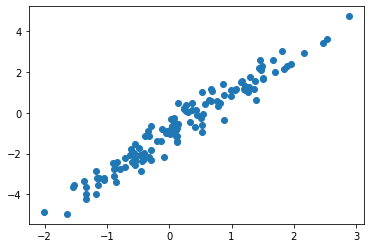

In [ ]:
#Lets create some data for the function with some noise => y = w*x + b +noise 
true_weights , true_bias = 2,-1
xs = np.random.normal(size=(128,1))
noise =  0.5*np.random.normal(size=(128,1))
ys = xs * true_weights + true_bias + noise

#Lets plot this linear distributed data
plt.scatter(xs,ys)
plt.show()


dsdsdsdsd

In [ ]:
#Creating a params class as a named tuple class 
class Params(NamedTuple):
  #Values are jax arrays
  weight: jnp.ndarray
  bias: jnp.ndarray

lr = 0.005

In [ ]:
#For iniitializing the model
#intializing rndom values to the weight and bias for our model
def init_model(rng):
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key,())
  bias = jax.random.normal(bias_key,())
  return Params(weight,bias)  #return as Params class values


In [ ]:
#Intialize the parameteres and replicate across devices
#to do the coputation in parallel
params = init_model(jax.random.PRNGKey(1))
n_devices=jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x]*n_devices), params)
print(replicated_params)

Params(weight=DeviceArray([-1.1521945, -1.1521945, -1.1521945, -1.1521945, -1.1521945,
             -1.1521945, -1.1521945, -1.1521945], dtype=float32), bias=DeviceArray([-1.1470189, -1.1470189, -1.1470189, -1.1470189, -1.1470189,
             -1.1470189, -1.1470189, -1.1470189], dtype=float32))


In [ ]:
#Reshape our normal data (generated above) so that we can use it with pmap() in parallel
#Split the data equally between the devices 
#such that the leading dimension of these arrays  is n_devices (or 8 in our case)
def reshape_for_pmap(data, n_devices):
  return data.reshape(n_devices, data.shape[0]//n_devices,*data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, xs.shape)
#This shape is now suitable for using pmap

(8, 16, 1) (128, 1)


I trained an MLP in my last post and rest of the architecture is almost similar to that. We are going to iterate our model for 1000 epochs this time. See below the update function and the training pipeline, and the final plot of model function --

In [ ]:
#forward pass
def forward(params, xs):
  return params.weight*xs + params.bias

#Compute least squares error of the model prediction on xs and ys
def loss_fn(params, xs, ys):
  pred = forward(params,xs) #params.weight*xs + params.bias
  return jnp.mean((pred - ys)**2)


#Performs SGD updates over the params using given data
#Using a decorator hhere, so that later we don't have to wrap this update function inside jax.pmap() wrapper
@functools.partial(jax.pmap,axis_name='p')
def update(params, xs, ys):

  #compute the gradients on the given minibatch (individually on each device)
  loss, grads = jax.value_and_grad(loss_fn)(params, xs,ys)

  #compute the gradient across all devices (by taking their mean)
  #Combining the output from all the cores
  #All the params are same across the devises, this makes gradient same as well -> updated params across all devices will be same as well
  grads = jax.lax.pmean(grads, axis_name='p')

  #Also combining the loss - useful for logging purposes
  loss = jax.lax.pmean(loss,axis_name='p')

  #Each device would perform its own gradient discent and updates
  new_params = jax.tree_multimap(lambda param, g: param - g*lr, params, grads) 

  return new_params, loss


def type_after_update(name, obj):
  print(f"After first `update()`,`{name}`is a {type(obj)}")

#Training loop
num_epochs = 1000
for epoch in range(num_epochs):

  #Sending params and data to devices
  #replicated_params and loss will be sharded device arrays
  replicated_params, loss = update(replicated_params, x_parallel, y_parallel) 

  #Checking if replicated_params and loss are sharded/ on device
  #Also showing that numpy arrays x_parallel, y_prallel are being streamed from the local CPU
  if epoch == 0:
    type_after_update('replicated_params.weight = ', replicated_params.weight)
    type_after_update('loss = ', loss)
    type_after_update('x_parallel', x_parallel)
  
  if epoch % 100 == 0:
    print(loss.shape)
    print(f"Step{epoch:3d}, loss: {loss[0]:.3f}")

#Looking at the params on the first device
#these final params will be duplicate on all device, as these are the final params and are getting update on all devices
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))
print(params)

After first `update()`,`replicated_params.weight = `is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
After first `update()`,`loss = `is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
After first `update()`,`x_parallel`is a <class 'numpy.ndarray'>
(8,)
Step  0, loss: 10.066
(8,)
Step100, loss: 1.486
(8,)
Step200, loss: 0.410
(8,)
Step300, loss: 0.251
(8,)
Step400, loss: 0.223
(8,)
Step500, loss: 0.218
(8,)
Step600, loss: 0.217
(8,)
Step700, loss: 0.217
(8,)
Step800, loss: 0.217
(8,)
Step900, loss: 0.217
Params(weight=array(1.9513664, dtype=float32), bias=array(-0.9838424, dtype=float32))


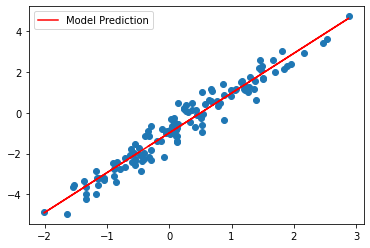

In [ ]:
plt.scatter(xs,ys)
plt.plot(xs,forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()

* In above otput, after printing after epoch 0, note that replicated_params.weight is a sharded device array meaning it is on the device or the core.

* Same can be said for loss -> sharded device array

* However, the data is a numpy array, or meaning it is locally stored on CPU. Keeping data on CPU rather then on TPU cores, make sense when you have large datasets and you ant to utilize TPUs for computations rather than storage.

* Notice the loss shape as (8,) -> an eight dimensional vector as it is sharded on different cores.

* Loss goes down till epoch 500 and then saturates

So, we just implemented our first MLP in **Parallel on 8 TPU cores.**

## Advanced Autodiff in JAX

* Right, so far in my articles on JAX, we have learned how to take gradient (Autodiff - grad() ) of functions and how it is put into use while updating your MLP (a neural network) through value_and_grad() function. 

* However, there are some use-cases in which you would want to ask JAX to stop calculating gradient for some layers of your neural network or your loss function, for example in transfer learning you would want to freeze some layers and train the rest.  

* Autodiff enables automatic computation of the gradient of a function with respect to its inputs. When we want to exercise more control on grad operation, we have a choice to use the ```jax.lax.stop_gradient``` to force JAX to ignore the gradient of a function.  

If you want to log both, your loss value and your gradients of the loss then you can us jax.value_and_grad() inbuilt function.
